## Smooth fishing pressure over a neighbourhood

#### Summary
*  Input fishing pressure rasters (3km resolution)
*  Choose size of neighbourhood
*  Calculate fishing pressure over inverse distance weighted neighbourhood (on 3km raster)


In [1]:
# Import necessary modules
import numpy as np # for array math
import rasterio # for reading and writing rasters and spatial indexing of rasters
import rasterio.plot # to plot rasters
import gdal # to build raster stats and pyramids
from matplotlib import pyplot as plt # for colourbar maps and histogram plot
import matplotlib.colors # for colour bins in raster map
import scipy.ndimage # for focal sum
import glob # for listing files in a directory
from pathlib import Path # for handling file paths

In [20]:
# Get raster list
raster_files = glob.glob("rasters/*.tif")

In [37]:
# Size (based on 3km resolution rasters)
distance = 51
size = (distance/3) + 2
print(size)

# Create export directory
export_dir = 'smoothed-rasters-' + str(distance) + 'km'
Path(export_dir).mkdir(parents=True, exist_ok=True)

19.0


In [38]:
# Smooth fishing pressure across a neighbourhood
# Using a distance weighted focal sum

# Function to smooth/interpolate the point density raster
# Size is the number of cells in the square neighbourhood (recommend choosing odd values)
def calc_smooth(size, raster_file, export_dir, distance):

    # Load raster and get array and profile
    raster = rasterio.open(raster_file)
    array = raster.read(1)
    #array[array==array.min()] = np.nan # low value (no data) to nan
    profile = raster.profile
    
    # Get proj info
    proj = raster.crs
    print('Raster projection: ' + str(proj.data))

    # If neighbourhood size is an even number
    if (size % 2) == 0:
        # Method for sequence when size is even
        lr = np.r_[0:1:size/2j]
        hor = np.concatenate([lr, np.flipud(lr)])
    else:
        # Method for sequence when size is odd
        hor = abs( abs(np.mgrid[-1:1:size/1j]) - 1 )
    # Weights array    
    xw,yw = np.meshgrid(hor, hor.T)
    weights = xw * yw
        
    # Convolution - uses 0 value at the edges
    smooth = scipy.ndimage.convolve(array, weights, mode='constant', cval=0)

    # Write smoothed point density array
    with rasterio.Env():
        # Write raster
        output_file = export_dir + '/' + Path(raster_file).stem + '_' + str(distance) + 'km.tif'
        with rasterio.open(output_file, 'w', **profile) as dataset:
            dataset.write(smooth.astype(rasterio.float32), 1)

    # Return
    return [array, weights]

#Calculate smoothed point density rasters
#Geotif output in rasters directory
for r in raster_files:
    a, w = smooth_files = calc_smooth(size=size, raster_file=r, export_dir=export_dir, distance=distance)  


Raster projection: {'proj': 'utm', 'zone': 9, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}
Raster projection: {'proj': 'utm', 'zone': 9, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}
Raster projection: {'proj': 'utm', 'zone': 9, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}
Raster projection: {'proj': 'utm', 'zone': 9, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}
Raster projection: {'proj': 'utm', 'zone': 9, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}
Raster projection: {'proj': 'utm', 'zone': 9, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}
Raster projection: {'proj': 'utm', 'zone': 9, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}
Raster projection: {'proj': 'utm', 'zone': 9, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}
Raster projectio

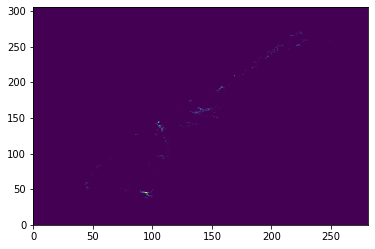

In [39]:
# input array from last item in loop
plt.pcolormesh(a)

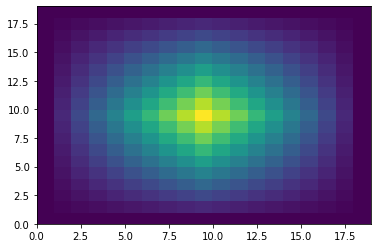

In [40]:
# convolution kernel
plt.pcolormesh(w)

In [41]:
# Get raster list
smooth_files = glob.glob(export_dir+"/*.tif")
smooth_files

['smoothed-rasters-51km/fishing_2000_51km.tif',
 'smoothed-rasters-51km/fishing_2001_51km.tif',
 'smoothed-rasters-51km/fishing_2002_51km.tif',
 'smoothed-rasters-51km/fishing_2003_51km.tif',
 'smoothed-rasters-51km/fishing_2004_51km.tif',
 'smoothed-rasters-51km/fishing_2005_51km.tif',
 'smoothed-rasters-51km/fishing_2006_51km.tif',
 'smoothed-rasters-51km/fishing_2007_51km.tif',
 'smoothed-rasters-51km/fishing_2008_51km.tif',
 'smoothed-rasters-51km/fishing_2009_51km.tif',
 'smoothed-rasters-51km/fishing_2010_51km.tif',
 'smoothed-rasters-51km/fishing_2011_51km.tif',
 'smoothed-rasters-51km/fishing_2012_51km.tif',
 'smoothed-rasters-51km/fishing_2013_51km.tif',
 'smoothed-rasters-51km/fishing_2014_51km.tif',
 'smoothed-rasters-51km/fishing_2015_51km.tif',
 'smoothed-rasters-51km/fishing_2016_51km.tif',
 'smoothed-rasters-51km/fishing_2017_51km.tif',
 'smoothed-rasters-51km/fishing_2018_51km.tif',
 'smoothed-rasters-51km/fishing_2019_51km.tif']

In [42]:
# Build pyramids and calcualte stats for all rasters

# Loop through raster files
for r in smooth_files:
    # Set to 1 (read/write) mode to set pyramids and stats internally
    raster = gdal.Open(r, 1)
    gdal.SetConfigOption('COMPRESS_OVERVIEW', 'DEFLATE')
    # BUild pyramids for all resolutions
    raster.BuildOverviews("NEAREST", [2,4,8,16,32,64,128,256,512,1024])
    # Caluclate stats
    raster.GetRasterBand(1).GetStatistics(0,1)
    del raster

In [43]:
# Example map of smoothed raster

# Load smoothed raster
with rasterio.open(smooth_files[0]) as raster:
    # Read as array
    array = raster.read(1)
    #array[np.isnan(array)] = 0 # low value (no data) to zero

    # Get quantile breaks
    f = array.flatten()
    f = f[f != 0] # without zeros
    q_breaks = np.arange(0.2, 1, 0.12).round(1).tolist()
    breaks = [0] + np.quantile(f, q_breaks).tolist() + [f.max()]
    # Get max value 
    maxval = array.max()
    # Set the colors
    cmap = matplotlib.colors.ListedColormap(['white','#3288bd','#99d594','#e6f598', 
                                             '#ffffbf','#fee08b','#fc8d59','#d53e4f'])
    # Define colors bins
    norm = matplotlib.colors.BoundaryNorm(breaks, 8)
    # Map
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title('Smoothed fishing pressure')
    img = ax.imshow(array, cmap=cmap, norm=norm)
    fig.colorbar(img, ax=ax);